## Principal Component Analysis (PCA)
Author: Adrien Loiseau

In [1]:
# Run the help_functions.py script to have acces to the imports and helper functions
%run help_functions.py

##### Load the dataset containing the 500 hPa geopotential height data

In [2]:
file_name = "Data/ERA5_geopotential_500hPa_1940_2025_winter_midnight_Euro_Atlantic.nc"
dataset_dict = load_dataset(file_name=file_name)

Geopotential height dataset (0.25°x0.25°): (nb_days=7731, nb_lats=241, nb_longs=561, grid_size=135201)
Geopotential height dataset (0.50°x0.50°): (nb_days=7731, nb_lats=121, nb_longs=281, grid_size=34001)
Geopotential height data: (7731, 121, 281)
Reshaped geopotential height data: (7731, 34001)
Geopotential height anomalies: (7731, 121, 281)
Reshaped geopotential height anomalies: (7731, 34001)
Daily winter data from 1940 to 2025 successfully loaded. Loading time: 49.10 seconds.


### Apply PCA to the geopotential height anomalies

In [3]:
nb_modes = 19
data_for_PCA = dataset_dict["geopotential_height_anomalies_reshaped"]

### Run PCA with nb_modes modes ###
start_time = time.time()
pca = PCA(n_components=nb_modes).fit(data_for_PCA)
end_time = time.time() ; print(f"PCA algorithm with {nb_modes} modes performed in {end_time-start_time:.2f} seconds.")

### Calculate the explained variance by the first nb_modes PCA modes ###
explained_variance = pca.explained_variance_ratio_ * 100
print(f"Total explained variance by the first {nb_modes} PCA modes: {explained_variance.sum():.2f}%")

### Transform the geopotential height anomalies using the PCA model (Project the data onto the first nb_modes PCA modes) ###
PCA_transformed_data = pca.transform(data_for_PCA)
print(f"Transformed geopotential height shape: {PCA_transformed_data.shape}")
print(f"Principal components shape: {pca.components_.shape}")

PCA algorithm with 19 modes performed in 4.97 seconds.
Total explained variance by the first 19 PCA modes: 90.70%
Transformed geopotential height shape: (7731, 19)
Principal components shape: (19, 34001)


### Evolution of the (cumulative) Proportion of Variance Explained (cPVE - PVE) by the first nb_modes PCA modes ###

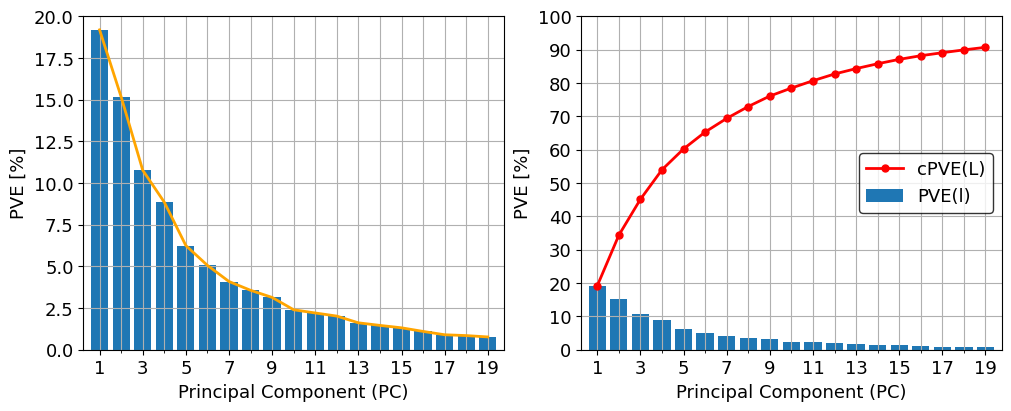

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)

nb_modes_array = np.arange(1, nb_modes+1, 1) 

axs[0].bar(x=nb_modes_array, height=explained_variance)
axs[0].plot(nb_modes_array, explained_variance, color='orange', linewidth=2)
axs[0].set_xlim(0.25, nb_modes+0.75) ; axs[0].set_ylim(0, 20)
axs[0].set_xlabel("Principal Component (PC)", fontsize=13) ; axs[0].set_ylabel("PVE [%]", fontsize=13) ; axs[0].tick_params(axis='both', labelsize=13)
axs[0].set_xticks(np.arange(1, nb_modes+1, 2)) ; axs[0].set_yticks(np.arange(0, 21, 2.5)) ; axs[0].grid(which='both') ; axs[0].set_xticks(nb_modes_array, minor=True)

cumulative_explained_variance = np.cumsum(explained_variance)
axs[1].plot(nb_modes_array, cumulative_explained_variance, color='r', label='cPVE(L)', linewidth=2, marker='o', markersize=5)
axs[1].bar(x=nb_modes_array, height=explained_variance, label='PVE(l)')
axs[1].set_xlim(0.25, nb_modes+0.75) ; axs[1].set_ylim(0, 100)
axs[1].set_xlabel("Principal Component (PC)", fontsize=13) ; axs[1].set_ylabel("PVE [%]", fontsize=13) ; axs[1].tick_params(axis='both', labelsize=13)
axs[1].legend(edgecolor='black', loc='center right', fontsize=13)
axs[1].set_xticks(np.arange(1, nb_modes+1, 2)) ; axs[1].set_yticks(np.arange(0, 101, 10)) ; axs[1].grid(which='both') ; axs[1].set_xticks(nb_modes_array, minor=True)

# plt.savefig(f"Images/explained_variance_{nb_modes}_PCA_modes.png", dpi=300, bbox_inches='tight')
plt.show()

### Plot the loading patterns of the first nb_modes PCA modes ###

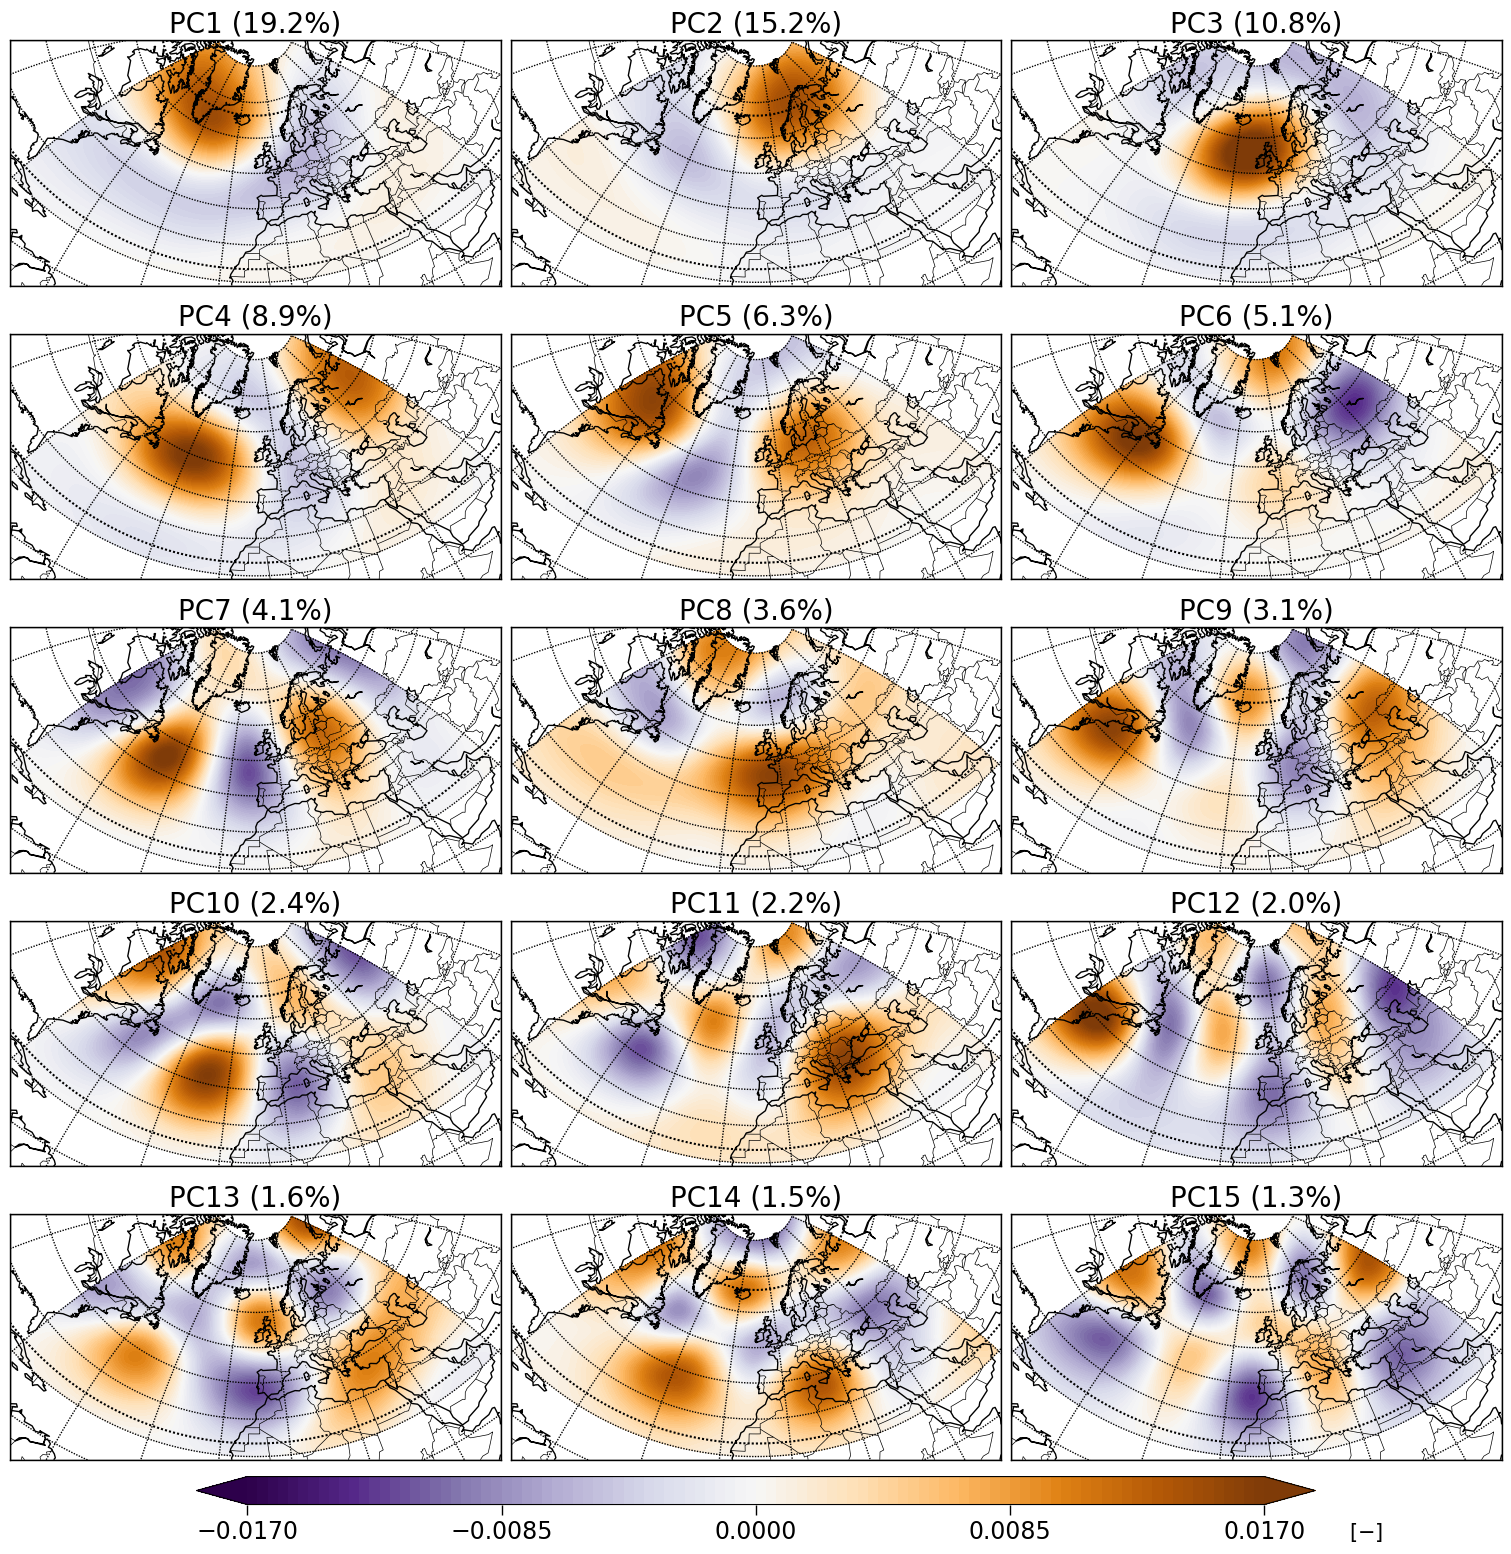

In [14]:
### Create figure and axes instances ###
nb_modes_to_plot = 15 ; ncols = 3 ; nrows = nb_modes_to_plot // ncols
fig, axs = plt.subplots(nrows=nrows, ncols=ncols, figsize=(ncols*5, nrows*3+0.5), constrained_layout=True)

for mode in range(nrows*ncols): # Loop over the modes indices (starting from 0 --> +1)
    row = mode // ncols ; col = mode % ncols ; axis_to_plot = axs[row, col]
    axis_to_plot.set_title(f"PC{mode+1} ({explained_variance[mode]:.1f}%)", fontsize=20)

    ### Create the contour plot ###
    nb_lats = len(dataset_dict["lats"]) ; nb_longs = len(dataset_dict["longs"])
    m, contour, ticks = create_contour_data(ax=axis_to_plot, dataset_dict=dataset_dict, type_plot="principal_component",
                                            geopotential_height_data_to_plot=(pca.components_[mode, :].reshape(nb_lats, nb_longs))) # Reshape the 1-D array to a 2-D array

### Add a colorbar under the last row of subplots ###
cbar = fig.colorbar(contour, ax=axs, ticks=ticks, location='bottom', extend='both', shrink=0.75, pad=0.01, aspect=40)
cbar.ax.tick_params(axis="x", labelsize=17, length=7.5, width=1)
cbar.ax.text(x=1.1, y=-1, s=r'$[-]$', transform=cbar.ax.transAxes, ha='center', va='center', fontsize=15)
# plt.savefig(f"Images/PCA_{nb_modes_to_plot}_PCs_{dataset_dict["first_year"]}_{dataset_dict["last_year"]}.png", dpi=300, bbox_inches='tight')
plt.show()

### Projection of the geopotential height anomalies onto the leading PCA modes throughout the winter of 2024-2025 ###

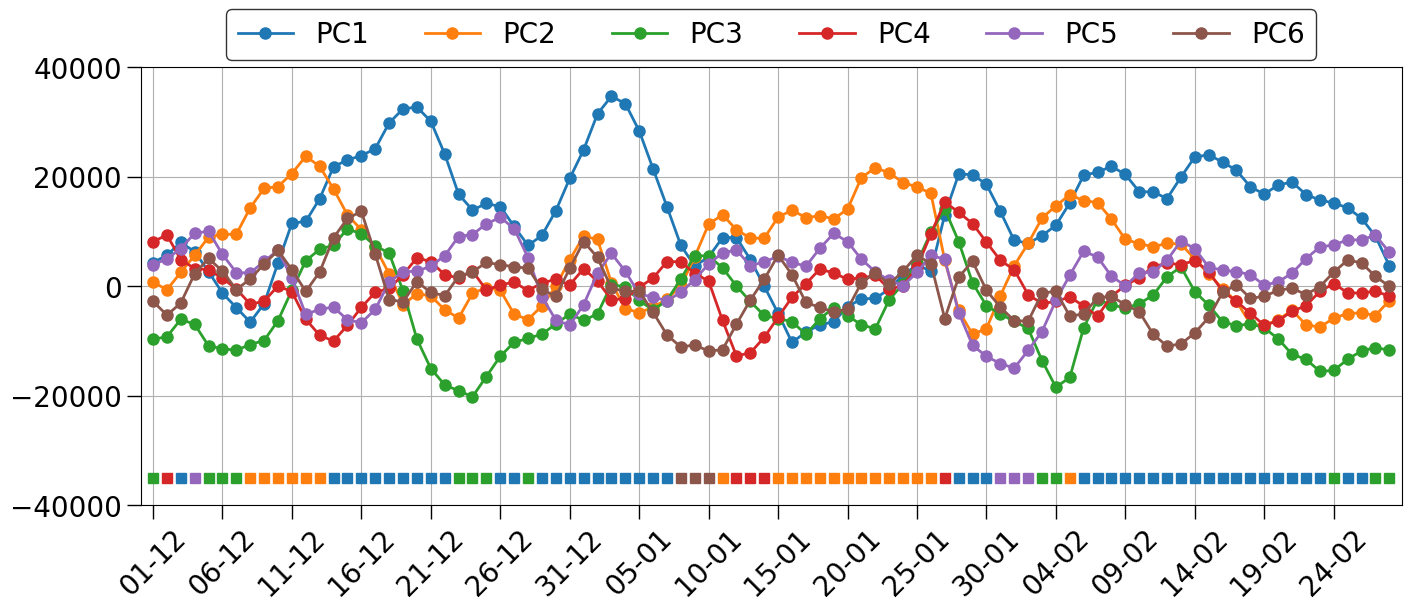

In [ ]:
nb_modes_to_plot = 6
winter_year = 2010
year_start_idx = 0 ; year_end_idx = 60
for year in range(dataset_dict["first_year"]+1, winter_year+1):
    if (year % 4 == 0): year_start_idx = year_end_idx ; year_end_idx += 91 # Leap year
    else: year_start_idx = year_end_idx ; year_end_idx += 90 # Non-leap year

nb_days_to_plot = (year_end_idx - year_start_idx)

fig, ax = plt.subplots(1, 1, figsize=(14, 6), constrained_layout=True)
for mode in range(nb_modes_to_plot): # Loop over the PCA modes (starting from 0 --> +1)
    plt.plot(PCA_transformed_data[year_start_idx:year_end_idx, mode], label=f"PC{mode+1}", marker='o', linewidth=2, markersize=8)

cmap = plt.get_cmap("tab10")
for day in range(year_start_idx, year_end_idx):
    plt.plot(day - year_start_idx, -35000, marker='s', markersize=7.5, color=cmap(np.argmax(np.abs(PCA_transformed_data[day, :nb_modes_to_plot]))))

### Set the dates as the x-axis labels ###
ticks_labels = [] ; months = ["12", "01", "02"]
for day in range(0, nb_days_to_plot, 5):
    month_idx = day // 31 ; day_in_month = day % 31
    ticks_labels.append(f"{day_in_month+1:02d}-{months[month_idx]}")
ax.set_xticks(ticks=np.arange(0, nb_days_to_plot, 5), labels=ticks_labels, rotation=45) ; plt.tick_params(axis='both', labelsize=20, length=10, width=1)

plt.legend(bbox_to_anchor=(0.5, 1.075), ncols=nb_modes_to_plot, loc='center', fontsize=20, edgecolor='black') ; plt.grid() ; plt.margins(x=0.01)
plt.ylim(-40000, +40000) # ; plt.ylim(ymin=-max(np.abs(plt.ylim())), ymax=max(np.abs(plt.ylim())))
# plt.savefig(f"Images/PCA_{nb_modes_to_plot}_modes_time_series_winter_{winter_year-1}_{winter_year}.png", dpi=300, bbox_inches='tight')
plt.show()

### Compute the contribution of each PCA mode to the projection of each day ###

In [8]:
nb_modes_to_plot = 10
labels = []
dates = dataset_dict["dates"] ; nb_dates = len(dates)
percentage_mode_attribution_array = np.zeros((nb_dates, nb_modes_to_plot))
positive_percentage_mode_attribution_array = np.zeros((nb_dates, nb_modes_to_plot))
negative_percentage_mode_attribution_array = np.zeros((nb_dates, nb_modes_to_plot))
for idx in range(len(dates)):
    percentage_mode_attribution_array[idx, :nb_modes_to_plot] = np.abs(PCA_transformed_data[idx, :nb_modes_to_plot]) / np.sum(np.abs(PCA_transformed_data[idx, :nb_modes_to_plot])) * 100
    labels.append(np.argmax(percentage_mode_attribution_array[idx, :]))
    positive_scores_idx = np.where(PCA_transformed_data[idx, :nb_modes_to_plot] >= 0)[0] ; negative_scores_idx = np.where(PCA_transformed_data[idx, :nb_modes_to_plot] < 0)[0]
    positive_percentage_mode_attribution_array[idx, positive_scores_idx] = np.abs(PCA_transformed_data[idx, positive_scores_idx]) / np.sum(np.abs(PCA_transformed_data[idx, :nb_modes_to_plot])) * 100
    negative_percentage_mode_attribution_array[idx, negative_scores_idx] = np.abs(PCA_transformed_data[idx, negative_scores_idx]) / np.sum(np.abs(PCA_transformed_data[idx, :nb_modes_to_plot])) * 100

sum = 0
for idx in range(nb_modes):
    print(f"Mode {idx+1} has {100 * np.sum(np.array(labels) == idx) / nb_dates:.2f}% belonging data points") ; sum += np.sum(np.array(labels) == idx)
    if (idx == 5): print(f'Modes 1 to {idx+1} have {100 * sum / nb_dates:.2f}% belonging data points')
    if (idx == 8): print(f'Modes 1 to {idx+1} have {100 * sum / nb_dates:.2f}% belonging data points')

Mode 1 has 28.75% belonging data points
Mode 2 has 23.01% belonging data points
Mode 3 has 16.76% belonging data points
Mode 4 has 11.40% belonging data points
Mode 5 has 7.02% belonging data points
Mode 6 has 4.80% belonging data points
Modes 1 to 6 have 91.75% belonging data points
Mode 7 has 3.62% belonging data points
Mode 8 has 2.12% belonging data points
Mode 9 has 1.81% belonging data points
Modes 1 to 9 have 99.30% belonging data points
Mode 10 has 0.70% belonging data points
Mode 11 has 0.00% belonging data points
Mode 12 has 0.00% belonging data points
Mode 13 has 0.00% belonging data points
Mode 14 has 0.00% belonging data points
Mode 15 has 0.00% belonging data points
Mode 16 has 0.00% belonging data points
Mode 17 has 0.00% belonging data points
Mode 18 has 0.00% belonging data points
Mode 19 has 0.00% belonging data points


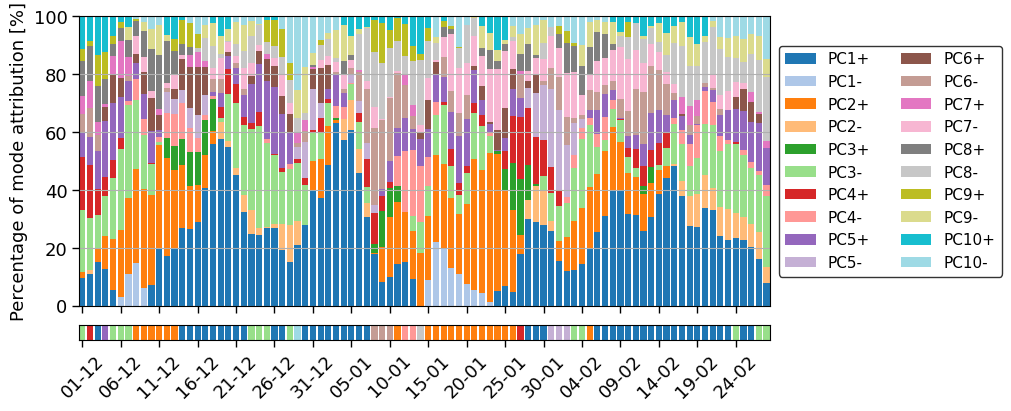

In [ ]:
### Plot the positive and negative mode attribution for each day of the winter season (DJF) ###
nb_modes_to_plot = 10

winter_year = 2010
year_start_idx = 0 ; year_end_idx = 60
for year in range(dataset_dict["first_year"]+1, winter_year+1):
    if (year % 4 == 0): year_start_idx = year_end_idx ; year_end_idx += 91 # Leap year
    else: year_start_idx = year_end_idx ; year_end_idx += 90 # Non-leap year

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(10, 4), constrained_layout=True, sharex=True, height_ratios=[20, 1])

cmap = plt.get_cmap('tab20') # Color map
bottom = np.zeros(year_end_idx-year_start_idx)
for mode in range(nb_modes_to_plot):
    axs[0].bar(x=np.arange(year_start_idx, year_end_idx, 1), height=positive_percentage_mode_attribution_array[:, mode][year_start_idx:year_end_idx], label=f"PC{mode+1}+", color=cmap(2*mode), bottom=bottom)
    bottom += positive_percentage_mode_attribution_array[:, mode][year_start_idx:year_end_idx]
    axs[0].bar(x=np.arange(year_start_idx, year_end_idx, 1), height=negative_percentage_mode_attribution_array[:, mode][year_start_idx:year_end_idx], label=f"PC{mode+1}-", color=cmap(2*mode+1), bottom=bottom)
    bottom += negative_percentage_mode_attribution_array[:, mode][year_start_idx:year_end_idx]

axs[0].legend(bbox_to_anchor=(1.175, 0.5), ncols=2, loc='center', fontsize=11, edgecolor='black') ; axs[0].set_ylabel("Percentage of mode attribution [%]", fontsize=13)
axs[0].margins(x=0, y=0) ; axs[0].tick_params(axis='both', labelsize=13) ; axs[0].tick_params(axis='both', labelsize=13, length=5, width=1) ; axs[0].set_ylim(ymin=0, ymax=100) ; axs[0].grid(axis='y')

### Add the direction of the mode with largest contribution for each day ###
colors = []
for idx in range(year_start_idx, year_end_idx):
    if (PCA_transformed_data[idx, labels[idx]] >= 0): colors.append(cmap(2*labels[idx])) # PC+
    else: colors.append(cmap(2*labels[idx]+1)) # PC-
axs[1].bar(x=np.arange(year_start_idx, year_end_idx, 1), height=1, color=colors)
axs[1].set_yticks([]) ; axs[1].margins(x=0, y=0) ; axs[1].tick_params(axis='both', labelsize=13, length=5, width=1)

### Set the dates as the x-axis labels ###
ticks_labels = []
months = ["12", "01", "02"]
for day in range(0, year_end_idx-year_start_idx, 5):
    month_idx = day // 31
    day_in_month = day % 31
    ticks_labels.append(f"{day_in_month+1:02d}-{months[month_idx]}")
axs[1].set_xticks(ticks=np.arange(year_start_idx, year_end_idx, 5), labels=ticks_labels, rotation=45)

# plt.savefig(f"Images/PCA_percentage_pos_neg_mode_attribution_winter_{winter_year-1}_{winter_year}.png", dpi=300, bbox_inches='tight')
plt.show()

### Proportion of days assigned to the positive and negative direction of the PCA modes ###

97.46475229595137


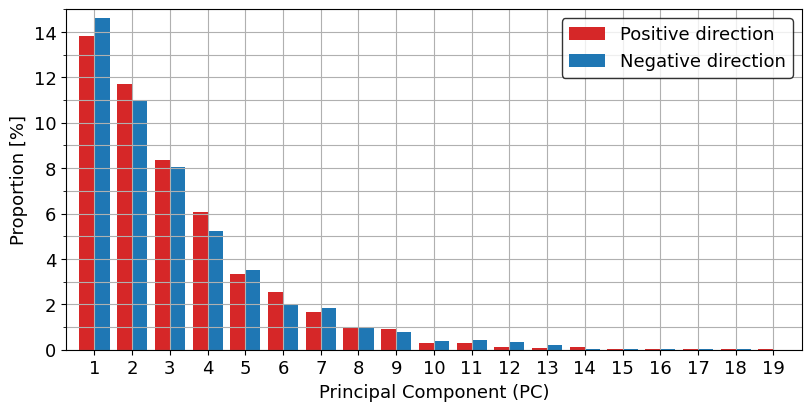

In [ ]:
nb_modes_to_keep = 19

### Assign the best mode for each day ###
best_mode = np.zeros(len(PCA_transformed_data))
for day in range(len(PCA_transformed_data)):
    best_mode[day] = np.argmax(np.abs(PCA_transformed_data[day]))
# print(f"Occurences of the best modes:\n{np.unique(best_mode, return_counts=True)}")

occurences = np.zeros(nb_modes)
occurences_positive = np.zeros(nb_modes) ; occurences_negative = np.zeros(nb_modes)
for mode in range(nb_modes):
    occurences[mode] = np.sum(best_mode == mode) / len(PCA_transformed_data) * 100
    occurences_positive[mode] = np.sum(PCA_transformed_data[best_mode == mode][:, mode] >= 0) / len(PCA_transformed_data) * 100
    occurences_negative[mode] = np.sum(PCA_transformed_data[best_mode == mode][:, mode] < 0) / len(PCA_transformed_data) * 100
    # print(f"Mode {mode+1}: {np.sum(best_mode == mode)} {np.sum(best_mode == mode)/len(best_mode)*100:.2f}%")
print(np.sum(occurences_positive[:9] + occurences_negative[:9]))

fig, ax = plt.subplots(1, 1, figsize=(8, 4), constrained_layout=True) ; nb_modes_to_keep = nb_modes
ax.bar(x=np.arange(1, nb_modes_to_keep+1, 1)-0.2, height=occurences_positive[:nb_modes_to_keep], width=0.4, color="tab:red", label="Positive direction")
# ax.bar_label(ax.containers[0], fmt='%.1f', fontsize=13)
ax.bar(x=np.arange(1, nb_modes_to_keep+1, 1)+0.2, height=occurences_negative[:nb_modes_to_keep], width=0.4, color="tab:blue", label="Negative direction")
# ax.bar_label(ax.containers[1], fmt='%.1f', fontsize=13)
ax.set_xlabel("Principal Component (PC)", fontsize=13) ; ax.set_ylabel("Proportion [%]", fontsize=13) ; ax.grid(which='both') ; ax.tick_params(axis='both', labelsize=13)
ax.set_xlim(0.25, nb_modes_to_keep+0.75) ; ax.set_ylim(0, 15) ; plt.legend(edgecolor='black', loc='upper right', fontsize=13)
ax.set_xticks(np.arange(1, nb_modes_to_keep+1, 1)) ; ax.set_yticks(np.arange(0, 15.1, 1), minor=True) ; ax.set_yticks(np.arange(0, 15.1, 2))
# plt.savefig(f"Images/best_PCA_modes_frequencies_pos_neg.png", dpi=300, bbox_inches='tight')
plt.show()

### Project the data onto the first two PCA modes ###

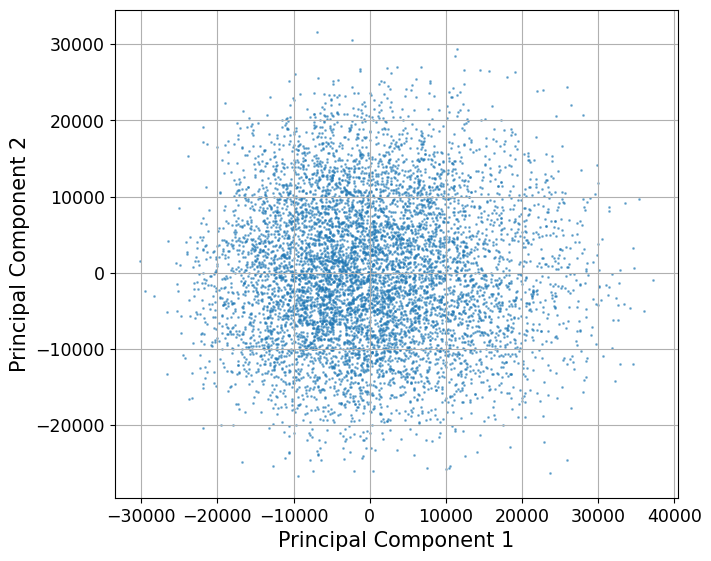

In [ ]:
plt.figure(figsize=(7, 7), constrained_layout=True) ; PCA_a = 0 ; PCA_b = 1
plt.scatter(PCA_transformed_data[:, PCA_a], PCA_transformed_data[:, PCA_b], s=1, alpha=0.5) ; plt.grid() ; plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel(f"Principal Component {PCA_a+1}", fontsize=15) ; plt.ylabel(f"Principal Component {PCA_b+1}", fontsize=15) ; plt.xticks(fontsize=12.5) ; plt.yticks(fontsize=12.5) 
# plt.savefig(f"Images/PCA_2D_projection_{dataset_dict["first_year"]}_{dataset_dict["last_year"]}.png", dpi=300, bbox_inches='tight')
plt.show()